# Import Packages

In [1]:

from Cloud_Loader import CloudDataset
# from GPUtil import showUtilization as gpu_usage
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from UNETplusplus import NestNet
import time
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from torch import cuda, nn
from torchmetrics import ConfusionMatrix

# Adjustables

In [2]:
# Minibatch Size
batch_size = 24
# Biggest so far without breaking: 100

# Import Data

## Import and Split Data

Keeping the same split so as to have consistency between the two datasets

In [3]:
# Set the base path and load in the dataset 
base_path = Path('Data/95-cloud_training')

data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')


# Split into training and testing data
train_ds , valid_ds , test_ds = torch.utils.data.random_split(data, [ 0.6 , 0.2 , 0.2 ],  generator=torch.Generator().manual_seed(42))

test_dl = DataLoader(test_ds ,
                                    batch_size = batch_size, 
                                    shuffle = True)

print(f' training dataset length: {len(test_ds)}')

display(len(test_ds))

 training dataset length: 6940


6940

# Model Evaluation

## Load the previous weights

In [5]:
# set the path to the modeled weights
path = 'UNETPP/UNET_PP_Weights.pth'
# path = 'UNET_Raw_Weights.pth'

# send everything to the GPU if available
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f' Running on {dev} ')

# Network
unet = NestNet(in_channels=4, n_classes=2)

# Load previous weights
unet.load_state_dict(torch.load(path))

# print out the network design
# unet.eval()



 Running on cuda:0 


<All keys matched successfully>

## Define the Loop

In [6]:
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.to(dev)).float().mean()

def test_loop(model, test_dl , loss_fn):
    start = time.time() 
    model.to(dev) # Send the model to the device
    test_loss , test_acc = [] , [] # create vectors for loss and acc
    best_acc = 0.0
    model.train(False) # We are not updating weights
    dataloader = test_dl

    # set losses and accuracies to 0 
    running_loss = 0.0 
    running_acc = 0.0
    step = 0

    # iterate over data
    for x, y in dataloader:
        step += 1
        if step % 2 == 0:
            # clear_output(wait=True)
             torch.cuda.empty_cache()
        x = x.to(dev)
        y = y.to(dev)
        with torch.no_grad():
            outputs = model(x)
            loss = loss_fn(outputs, y.long())
    
        # stats - whatever is the phase
            acc = acc_metric(outputs, y)

            running_acc  += acc*dataloader.batch_size
            running_loss += loss*dataloader.batch_size 
            # print(step % 100)
        # if step % 10 == 0:
        #     clear_output(wait=True)


    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_acc / len(dataloader.dataset)
    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_acc}')
    
    return test_loss , test_acc   

# Run the Test

In [7]:
loss_fn = nn.CrossEntropyLoss()
test_loss , test_acc = test_loop(unet , test_dl, loss_fn)


Training complete in 11m 48s
Test Loss: 0.48007333278656006
Test Accuracy: 0.8230893015861511


In [8]:
test_acc =  np.asarray(test_acc.cpu())
test_loss =  np.asarray(test_loss.cpu())

In [9]:
# Transfer the batch to images
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

# Predictions to of
def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

xb, yb = next(iter(test_dl))

with torch.no_grad():
    predb = unet(xb.to(dev))
predb.shape

torch.Size([24, 2, 384, 384])

# Confusion Matrix

In [10]:
# confusion matrix equation
confmat = ConfusionMatrix(task="binary", num_classes=2)
CM = np.zeros((2,2), dtype = int) # Start with 0s
PP = np.zeros(batch_size, dtype = int)


for i in range(batch_size):
    # prediction
    preds = predb_to_mask(predb, i)
    # Mask
    target = yb[i]
    # matrix of prediction
    CMi = confmat(preds, target).numpy()
    CM += CMi # Add them all up

# Calculate the percentage matrix
Tp = np.sum(CM) # Total Pixels
PCM = CM/Tp*100 # % of each occurance
PCM = CM.round(decimals = 1) # Round for readability
display(PCM)

# Total Confusion Matrix (Mastix of the raw values)
TCM = CM
display(TCM)

array([[2166535,  118878],
       [ 363524,  890007]])

array([[2166535,  118878],
       [ 363524,  890007]])

### Confusion Matrix Stats

In [17]:
Net_Acc = (test_acc*100).round(decimals = 2)  # Network Accuracy
Net_Acc = Net_Acc.astype(float)
Net_Loss = test_loss.astype(float)
TP = CM[0][0]   # True positive
FN = CM[0][1]  # False Negative
FP = CM[1][0]   # False Positive
TN = CM[1][1]  # True Negative
P =  TP + FN    # Positive
N = FP + TN    # Negative
PP = TP+FP # Predicted Positive
PN = FN + TN # Predicted Negative
T = P+N     # Total population
TPR = TP/P.round(decimals = 2)       # True Positivity Rate
FNR = 1 - TPR  # False Negative Rate
FPR = FP/N.round(decimals = 2)       # False Positive Rate
TNR = 1 - FPR  # True Negative Rate
Prev = P/(P+N) # Prevalence
ACC = (TP+TN)/(T+N).round(decimals = 2) # Accuracy
BA = ((TPR+TNR)/2).round(decimals = 2) # Balanced Accuracy
PPV = TP/PP # Positive Predictive value
FDR = 1 - PPV # False Discovery Rate
FOR = FN/PN # False Omission Rate
NPV = 1 - FOR # Negative Predictive Value
LRP = TPR/FPR # Positive likeliehood ratio
LRN = FNR/TNR # Negative Likeliehood Ratio
MK = PPV+NPV - 1 # Markedness, delta P
DOR = LRP/LRN  # Diagnostic odds ratio
TS = TP/(TP+FN+FP) # Threat Score/Critical Success Index
MCC = np.sqrt(TPR*TNR*PPV*NPV) # Mathews Correlation Coefficient
FM = np.sqrt(PPV*TPR) # Faowlkes-Mallows index
F = 2*TP/(2*TP + FP + FN) # F1 Score
BM = TPR+TNR -1 # Bookmaker Informedness
PT = (np.sqrt(TPR*FPR)-FPR)/(TPR-FPR) # Prevalence Threshold
type(PT)

numpy.float64

In [19]:
# Save Results in dictionary
dict = {
    'Testing Accuracy' : Net_Acc ,  
    'Testing Loss' : Net_Loss,
    'True Positive (TP)' : TP ,
    'False Negative (FN)' : FN ,
    'False Positive (FP)' : FP,
    'True Negative (TN)' : TN ,
    'Positive (P)' : P,
    'Negative (N)' : N,
    'Predicted Positive (PP)' : PP,
    'Predicted Negative (PN)' : PN,
    'Total Population (T) ' : T,
    'True Positivity Rate (TPR)' : TPR,
    'False Negativity Rate (FNR)' : FNR,
    'False Positivity Rate (FPR)' : FPR,
    'True Negative Rate (TNR)' : TNR ,
    'Prevalence (Prev)' : Prev,
    'Accuracy (ACC)': ACC,
    'Balanced Accuracy (BA)' : BA ,
    'Positive Predictive Value (PPV)' : PPV ,
    'False Discovery Rate (FDR)' : FDR,
    'False Omission Rate (FOR)' : FOR,
    'Negative Positivity Rate (NPV)' : NPV,
    'Positive Likeliehood Ratio (LRP)' : LRP,
    'Negative Likeliehood Ratio (LRN)' : LRN,
    'Markedness (MK)' : MK,
    'Diagnostic Odds Ratio (DOR)' : DOR,
    'Threat Score (TS)' :TS,
    'Mathews Correlation Coefficient (MCC)' : MCC,
    'Fawlkes-Mallows Index (FM)' : FM,
    'F1 Score (F)' : F,
    'Bookmaker Informedness (BM)' : BM, 
    'Prevalence Threshold (PT)' : PT,
}

df = pd.DataFrame([dict] ,
    #  columns = 'UNet' ,
    index = {'UnetPP'},
     )
df = df.transpose()
# df.rename(index={'T' : 0})
display(df)
df.to_csv('UNETPP/PP_Unet_Matrix_Stats.csv')

,UnetPP
Testing Accuracy,82.31
Testing Loss,0.48007333278656006
True Positive (TP),2166535
False Negative (FN),118878
False Positive (FP),363524
True Negative (TN),890007
Positive (P),2285413
Negative (N),1253531
Predicted Positive (PP),2530059
Predicted Negative (PN),1008885


## Images

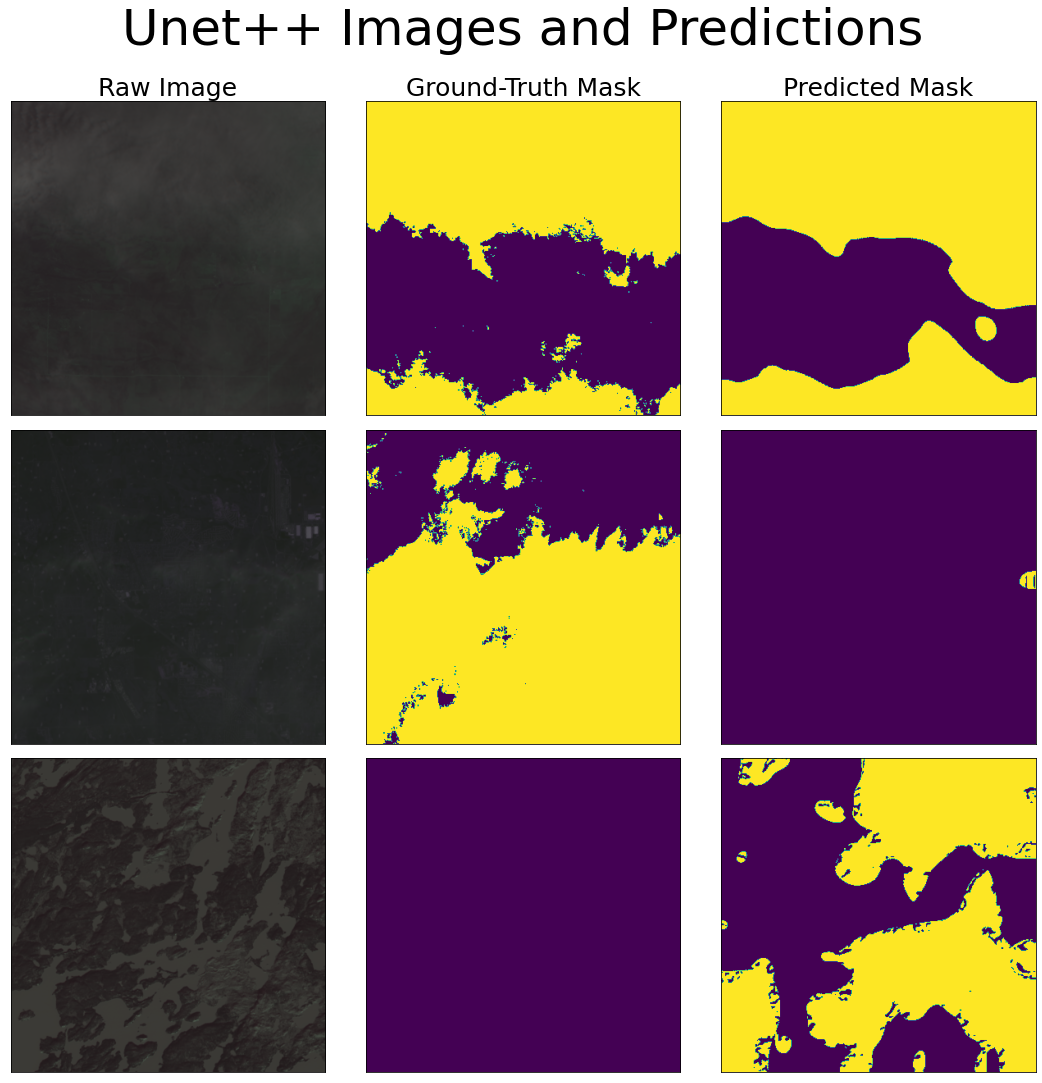

In [21]:
bs = [4 , 1 , 7 ]
fig, ax = plt.subplots( 3 , 3 , figsize=(15,15))
for r , i in enumerate(bs):
    ax[r,0].imshow(batch_to_img(xb,i))
    ax[r,0].get_xaxis().set_visible(False)
    ax[r,0].get_yaxis().set_visible(False)
    
    ax[r,1].imshow(yb[i])
    ax[r,1].get_xaxis().set_visible(False)
    ax[r,1].get_yaxis().set_visible(False)
    
    ax[r,2].imshow(predb_to_mask(predb, i))
    ax[r,2].get_xaxis().set_visible(False)
    ax[r,2].get_yaxis().set_visible(False)

# Labels and adjustments
column_text = '25' # text size for labels
ax[0,0].set_title('Raw Image', fontsize = column_text)
ax[0,1].set_title('Ground-Truth Mask', fontsize = column_text)
ax[0,2].set_title('Predicted Mask', fontsize = column_text)

plt.suptitle('Unet++ Images and Predictions',  # Set the overall title
    fontsize = 50,# Fontsize
    y = 1)  # Title position
    
plt.tight_layout()
plt.show()

[ 4  1 22  7]


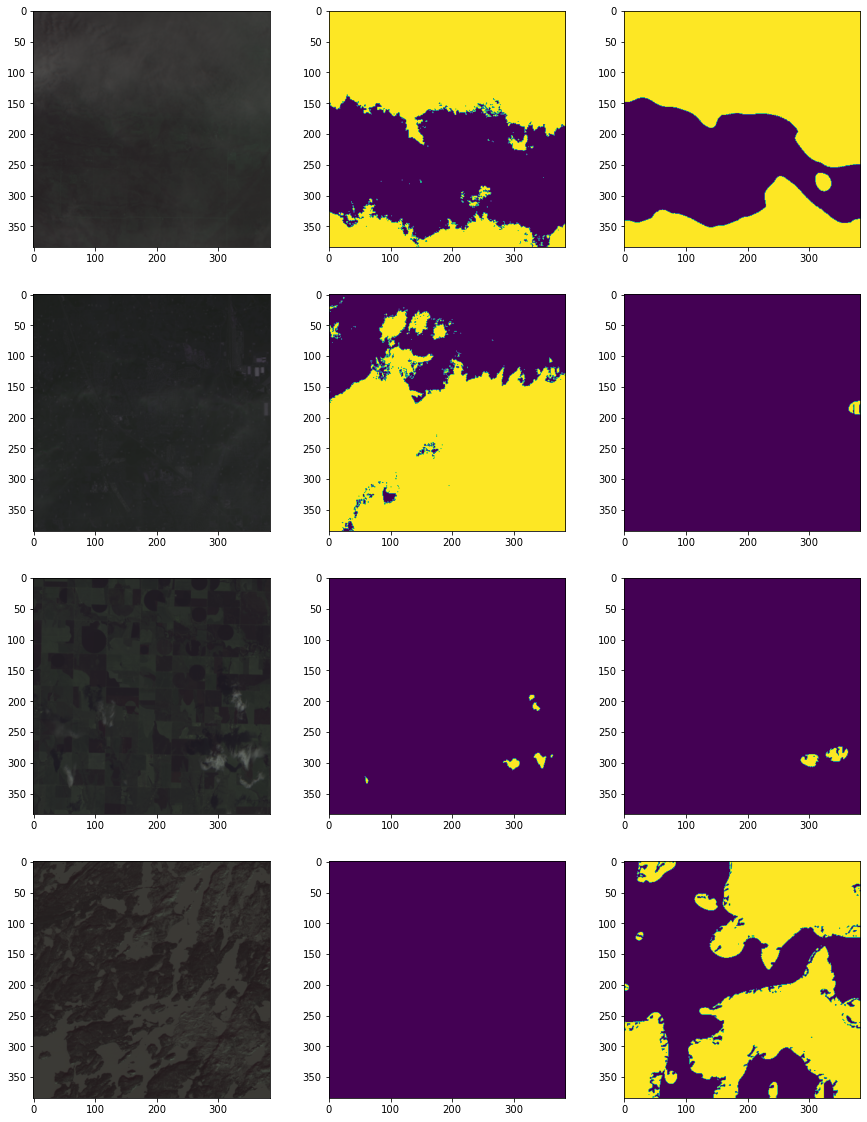

In [13]:
bs = 4
l = np.random.randint(batch_size , size = bs)
print(l)
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for r , i in enumerate(l):
    ax[r,0].imshow(batch_to_img(xb,i))
    ax[r,1].imshow(yb[i])
    ax[r,2].imshow(predb_to_mask(predb, i))